* David Araujo Garcia 1671077
* Enric Ortega Barreda 1672973

# Introducció

* L'objectiu principal d'aquest treball és analitzar i processar una base de dades d'imatges extretes de tràilers de pel·lícules per a tasques de predicció de frames. La base de dades ha estat construïda consolidant frames de diverses pel·lícules, extrets directament dels seus tràilers.

# Recopilació de dades pel Dataset

* Per a aquest treball no hem utilitzat cap base de dades disponible a internet, sinó que n’hem creat una de pròpia. Per fer-ho, inicialment hem descarregat els tràilers de deu pel·lícules diferents. A partir d’aquests tràilers, hem extret 10 fragments de 5 segons per a cada pel·lícula i, posteriorment, hem generat els frames corresponents per tal de construir una base de dades amb un total de deu fragments per a cada pel·lícula.




Per automatitzar el procés i ser més eficients, hem desenvolupat un programa en Python que retalla automàticament cada tràiler en fragments de 5 segons. Aquesta eina ens ha permès processar tots els tràilers de manera ràpida i uniforme, assegurant que cada pel·lícula estigui representada amb fragments consistents.


In [1]:
from moviepy.video.io.VideoFileClip import VideoFileClip

def recortar_video_en_fragmentos(video_path, output_folder, duration=5):
    video = VideoFileClip(video_path)
    video_duration = video.duration  
    fragmentos = int(video_duration // duration)  
    
    for i in range(fragmentos):
        start_time = i * duration
        end_time = start_time + duration
        
        fragment = video.subclip(start_time, end_time)
        
        output_path = f"{output_folder}/fragmento_{i+1}.mp4"
        fragment.write_videofile(output_path, codec="libx264")
    
    if video_duration % duration != 0:
        start_time = fragmentos * duration
        fragment = video.subclip(start_time, video_duration)
        output_path = f"{output_folder}/fragmento_{fragmentos + 1}.mp4"
        fragment.write_videofile(output_path, codec="libx264")



Un cop retallat el tràiler en fragments de 5 segons, hem seleccionat aquells que millor s’adaptaven a les necessitats del nostre model. Hem prioritzat els fragments amb menys transicions abruptes, menys fosos a negre i escenes més uniformes. Aquest procés ens ha permès crear una base de dades més homogènia i optimitzada per garantir un millor rendiment durant l’entrenament del model.


Després de seleccionar els fragments més adequats per a cada pel·lícula, hem desenvolupat un programa per automatitzar el procés de conversió de vídeo a frames. L’objectiu és desglossar cada fragment seleccionat en imatges fixes que puguin ser utilitzades com a dades d’entrada per al model. 


In [2]:
import cv2
import os
from datetime import datetime

def video_to_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"FPS: {fps}, Total Frames: {frame_count}")

    frame_num = 0

    while True:
        ret, frame = video.read()
        if not ret:
            break

        frame_filename = os.path.join(output_folder, f"{timestamp}_frame_{frame_num:04d}.jpg")
        cv2.imwrite(frame_filename, frame)

        frame_num += 1

    video.release()
    print(f"Extracción completada. Frames guardados en {output_folder}")



Per enriquir el nostre dataset amb informació addicional sobre cada frame, hem calculat dues característiques visuals: **brillantor promig** i **contrast**. 

1. **Brillantor Promig**: Aquesta característica mesura la lluminositat general d’un frame. Es calcula convertint la imatge al format HSV i obtenint la mitjana del canal de valor (V), que representa la brillantor de cada píxel.

2. **Contrast**: Aquesta característica quantifica la diferència entre els píxels més foscos i més clars d’un frame. Es calcula com la diferència entre els valors màxim i mínim de la imatge en escala de grisos.

Amb aquestes dues característiques, podem analitzar la qualitat visual de cada frame i incloure informació rellevant que podria influir en el rendiment del model o ser útil en anàlisis posteriors.


In [13]:
import cv2
import numpy as np
import pandas as pd

def calcular_brillantor_promig(frame_path):
    frame = cv2.imread(frame_path)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    brillantor = np.mean(hsv[:, :, 2]) 
    return brillantor

def calcular_contrast(frame_path):
    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) 
    contrast = np.max(frame) - np.min(frame)
    return contrast

Per tal de consolidar la informació de tots els frames en un únic dataset estructurat, hem creat una funció que automatitza el procés d'afegir dades de cada carpeta de frames al fitxer CSV definitiu. Aquesta funció, `agregar_carpeta_al_csv`, no només registra atributs bàsics com la ruta de cada imatge, el nom de la pel·lícula i el número de frame, sinó que també inclou característiques visuals com el **contrast** i la **brillantor promig** per enriquir el dataset.


In [25]:
import os
import csv

def agregar_carpeta_al_csv(carpeta_imagenes, archivo_csv, nombre_pelicula):
   
    with open(archivo_csv, mode='a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        
        if os.stat(archivo_csv).st_size == 0:
            writer.writerow(['ruta_imatge', 'pelicula', 'Nombre_frame','Contrast','Brillantor_promig'])  

        frame_numero = 1  
        for nombre_imagen in sorted(os.listdir(carpeta_imagenes)):
            ruta_imagen = os.path.join(carpeta_imagenes, nombre_imagen)
            ruta_imagen = ruta_imagen.replace("\\", "/")

            
            if os.path.isfile(ruta_imagen) and nombre_imagen.lower().endswith(('.jpg')):
                frame_numero_formateado = "'" + str(frame_numero).zfill(4)
                Contraste=calcular_contrast(ruta_imagen)
                Brillo_promedio = calcular_brillantor_promig(ruta_imagen)
                writer.writerow([ruta_imagen, nombre_pelicula, frame_numero_formateado, Contraste, Brillo_promedio ])
                
                frame_numero += 1

    print(f"Información de la carpeta '{carpeta_imagenes}' añadida al archivo CSV '{archivo_csv}'")
    

Información de la carpeta './APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES' añadida al archivo CSV 'C:/Users/enric/APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_DATASET_FINAL.csv'


# 1. EDA (exploratory data analysis)

In [4]:
import os
os.chdir('C:/Users/enric')  # Cambia el directorio actual

In [5]:
import pandas as pd
path = "./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_DATASET_FINAL.csv"
df = pd.read_csv(path, encoding='latin1')

In [6]:
#Mirem el dataset
print(df.shape[1])
print (df.keys())
#Mirem els tipus de les columnes
print (df.dtypes)
#Mirem el tamany
print (df.size)

#Mirem descripcio general
print (df.describe())
df.head()

5
Index(['ruta_imatge', 'pelicula', 'Nombre_frame', 'Contrast',
       'Brillantor_promig'],
      dtype='object')
ruta_imatge           object
pelicula              object
Nombre_frame          object
Contrast               int64
Brillantor_promig    float64
dtype: object
59205
           Contrast  Brillantor_promig
count  11841.000000       11841.000000
mean     223.454522          69.232419
std       47.360101          39.197502
min        0.000000           0.000000
25%      216.000000          38.128139
50%      243.000000          65.548841
75%      253.000000          97.596820
max      255.000000         191.092712


,ruta_imatge,pelicula,Nombre_frame,Contrast,Brillantor_promig
0,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0001,186,57.048197
1,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0002,187,56.852338
2,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0003,187,55.830400
3,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0004,186,53.021832
4,./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...,APOCALYPSE_NOW,'0005,187,48.718699


### Anàlisi Inicial del Dataset

Després d'una revisió inicial del dataset, podem destacar els següents punts rellevants:

1. **Dimensió i Columnes**:
   - El dataset conté un total de 5 columnes: `ruta_imatge`, `pelicula`, `Nombre_frame`, `Contrast`, i `Brillantor_promig`.
   - Té un total de 11.841 registres (frames), amb una mida total de 59.205 elements.


2. **Tipus de Dades**:
   - Les variables `ruta_imatge` i `pelicula` són de tipus `object`, adequades per emmagatzemar informació textual.
   - `Nombre_frame` és també de tipus `object` perquè conté un `'` (apòstrof) al començament de cada valor (per exemple, `'0001`). Això es va implementar per evitar que Excel convertís valors com `0001` a `1` automàticament.
   - Les variables numèriques, `Contrast` i `Brillantor_promig`, són de tipus `int64` i `float64`, respectivament.


In [7]:
# Dimensions del Dataset
num_frames = len(df)
num_pellicules = df['pelicula'].nunique()
print(f"Nombre de pel·lícules representades: {num_pellicules}")

# Distribució de Frames per Pel·lícula
distribucio_frames = df['pelicula'].value_counts()
print("Distribució de frames per pel·lícula:")
print(distribucio_frames)

Nombre de pel·lícules representades: 10
Distribució de frames per pel·lícula:
THE_SHINNING        1500
CASABLANCA          1200
THE_GODFATHER_II    1200
GOODFELLAS          1200
SCARFACE            1200
BARBIE              1198
TORRENTE            1176
LA_LA_LAND          1152
APOCALYPSE_NOW      1126
THE_GODFATHER        889
Name: pelicula, dtype: int64


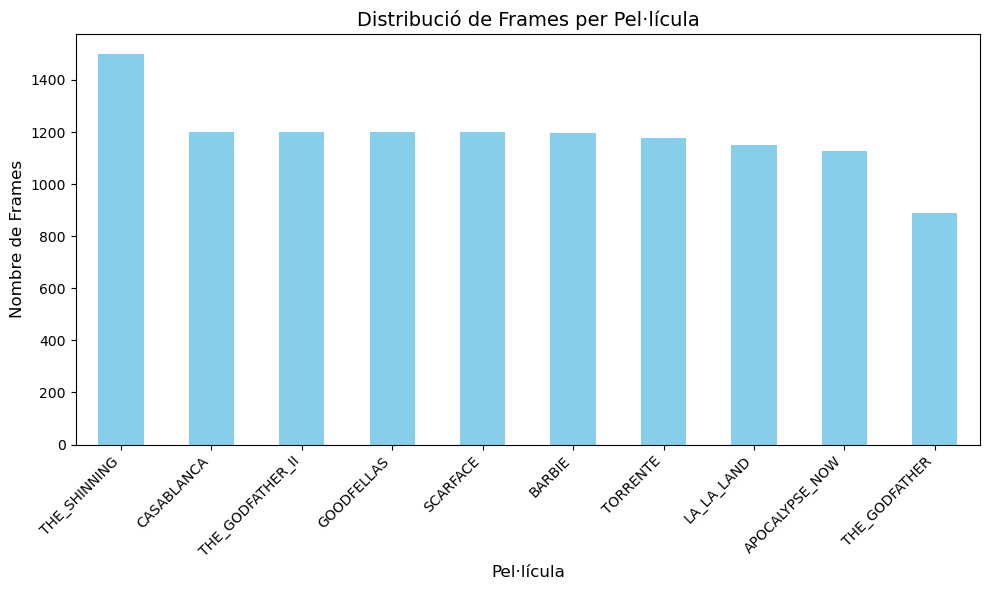

In [8]:
import matplotlib.pyplot as plt

# Gràfic de barres per la distribució
plt.figure(figsize=(10, 6))
distribucio_frames.plot(kind='bar', color='skyblue')
plt.title("Distribució de Frames per Pel·lícula", fontsize=14)
plt.xlabel("Pel·lícula", fontsize=12)
plt.ylabel("Nombre de Frames", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


# 2. Preprocessing

### Tractament de Frames Negres com a Dades Nul·les

En aquest projecte, tot i que la base de dades no conté valors nuls tradicionals, hem identificat frames amb imatges totalment negres, generalment deguts a transicions entre escenes o fossos en negre. Tractarem aquestes imatges com a NaNs, ja que no aporten informació visual significativa per a l'anàlisi o l'entrenament del model. Aquest criteri ens permet gestionar de manera efectiva les dades menys útils dins del dataset.


In [9]:
from collections import Counter

# Detecció de NaNs
missing_values = []
count = 0
brillantor = df["Brillantor_promig"]
pelicula = df["pelicula"]

for i in range(len(brillantor)):
    if brillantor[i] <= 5:  # Considerem NaNs si el valor és <= 5
        count += 1
        missing_values.append(pelicula[i])

print("Tenim un total de", count, "NaNs")

# Comptar el nombre de NaNs per pel·lícula
compt = Counter(missing_values)

# Incloure totes les pel·lícules, encara que no tinguin NaNs
pelicules_totals = df['pelicula'].unique()
pelicules = list(pelicules_totals)
num_nans = [compt[pelicula] if pelicula in compt else 0 for pelicula in pelicules]

# Mostrar resultats
print("Nombre de NaNs per pel·lícula:")
for pelicula, num in zip(pelicules, num_nans):
    print(f"{pelicula}: {num} NaNs")


Tenim un total de 192 NaNs
Nombre de NaNs per pel·lícula:
APOCALYPSE_NOW: 68 NaNs
BARBIE: 10 NaNs
CASABLANCA: 17 NaNs
THE_GODFATHER: 70 NaNs
THE_GODFATHER_II: 0 NaNs
GOODFELLAS: 0 NaNs
SCARFACE: 0 NaNs
THE_SHINNING: 16 NaNs
TORRENTE: 4 NaNs
LA_LA_LAND: 7 NaNs


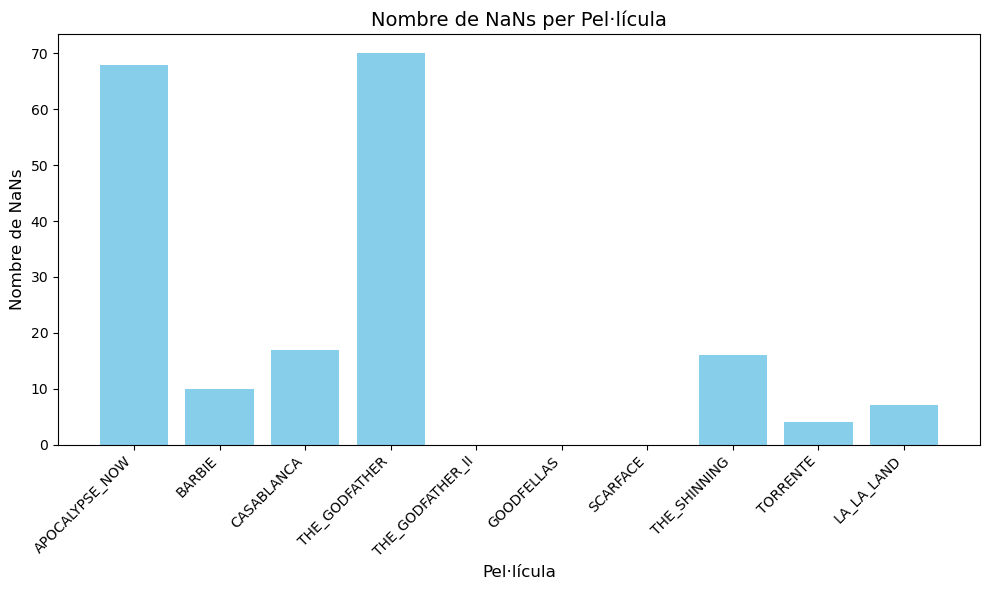

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

# Preparar les dades
pelicules_totals = df['pelicula'].unique()  # Llista completa de pel·lícules
pelicules = list(pelicules_totals)  # Convertir a llista
num_nans = [compt[pelicula] if pelicula in compt else 0 for pelicula in pelicules]  # Comptar NaNs o assignar 0

# Generar el gràfic de barres
plt.figure(figsize=(10, 6))
plt.bar(pelicules, num_nans, color='skyblue')  # Utilitzem les dades de pel·lícules i NaNs
plt.title("Nombre de NaNs per Pel·lícula", fontsize=14)
plt.xlabel("Pel·lícula", fontsize=12)
plt.ylabel("Nombre de NaNs", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotació dels noms de les pel·lícules
plt.tight_layout()
plt.show()


Finalment, eliminem totes les instàncies de la base de dades que continguin valors considerats com a NaNs, ja que no aporten informació rellevant per al nostre estudi. A més, hem establert un llindar mínim per a la variable `Brillantor_promig`, de manera que qualsevol instància amb un valor per sota d'aquest llindar també serà eliminada definitivament. Aquesta depuració ens assegura que la base de dades resultant només inclou imatges significatives i adequades per al nostre objectiu d'anàlisi.

In [11]:
indexos_amb_NaNs=df[df["Brillantor_promig"]<=5].index
df=df.drop(indexos_amb_NaNs)
NaNs=(df["Brillantor_promig"]<=5).sum()
print(NaNs)

0


### Aplicació de LabelEncoder

Aplicarem **LabelEncoder** per transformar les següents variables categòriques en valors numèrics:
- **`pelicula`**: Per convertir els noms de les pel·lícules en valors numèrics que els models de machine learning puguin processar.


In [12]:
from sklearn.preprocessing import LabelEncoder


# Escollir les columnes a codificar
columnes_a_codificar = ['pelicula']  # Llista de columnes categòriques

# Aplicar LabelEncoder a cada columna
label_encoders = {}  # Per guardar els encoders per si vols revertir després
for col in columnes_a_codificar:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Emmagatzemar el LabelEncoder per a aquesta columna

# Mostrar el dataset amb les columnes codificades
print(df.head())

# Exemple: recuperar els valors originals d'una columna
columna_original = 'pelicula'
print("Valors decodificats:", label_encoders[columna_original].inverse_transform(df[columna_original][:5]))


                                         ruta_imatge  pelicula Nombre_frame  \
0  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0001   
1  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0002   
2  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0003   
3  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0004   
4  ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINA...         0        '0005   

   Contrast  Brillantor_promig  
0       186          57.048197  
1       187          56.852338  
2       187          55.830400  
3       186          53.021832  
4       187          48.718699  
Valors decodificats: ['APOCALYPSE_NOW' 'APOCALYPSE_NOW' 'APOCALYPSE_NOW' 'APOCALYPSE_NOW'
 'APOCALYPSE_NOW']


### Normalization
Per tal de garantir la coherència i facilitar l'anàlisi, hem aplicat processos de normalització a diferents aspectes de les dades:

1. **Mida de les imatges**:
   - Tots els frames han estat redimensionats a una mida comuna i única. Aquesta uniformitat és essencial per treballar amb xarxes neuronals o altres tècniques d'anàlisi d'imatges que requereixen inputs de dimensions fixes.


In [47]:
import cv2
import os

def redimensionar_imagenes(df, nuevo_tamano=(1024, 1024)):
    """
    Redimensiona las imágenes a un tamaño uniforme y las guarda en una carpeta de salida.

    :param rutas_imagenes: Lista de rutas de las imágenes a procesar.
    :param nuevo_tamano: Tupla (ancho, alto) para redimensionar las imágenes.
    :param carpeta_salida: Carpeta donde se guardarán las imágenes redimensionadas.
    """

    for index,row in df.iterrows():
        ruta = row['ruta_imatge'] 
        
        try:
            # Leer la imagen
            img = cv2.imread(ruta)
            if img is not None:
                
                img_redimensionada = cv2.resize(img, nuevo_tamano, interpolation=cv2.INTER_AREA)
                # Obtener el nombre del archivo original
                cv2.imwrite(ruta, img_redimensionada)
            else:
                print(f"No se pudo leer la imagen: {ruta}")
        except Exception as e:
            print(f"Error al procesar la imagen {ruta}: {e}")
    return df
df=redimensionar_imagenes(df, nuevo_tamano=(1024, 1024))

In [48]:
#NORMALITZACIÓ DADES

import cv2

def comprobar_tamano_imagenes(rutas_imagenes):
    """
    Comprueba el tamaño (ancho x alto) de las imágenes dadas sus rutas.

    :param rutas_imagenes: Lista de rutas de las imágenes.
    :return: Diccionario con el tamaño de cada imagen y cuántas imágenes tienen cada tamaño.
    """
    tamanos = {}
    
    for ruta in rutas_imagenes:
        # Leer la imagen
        img = cv2.imread(ruta)
        if img is not None:
            altura, anchura = img.shape[:2]
            tamano = (anchura, altura)
            # Contar el tamaño de la imagen
            if tamano in tamanos:
                tamanos[tamano] += 1
            else:
                tamanos[tamano] = 1
        else:
            print(f"No se pudo leer la imagen: {ruta}")
    
    return tamanos

# Usar la función con las rutas del dataset
rutas = df['ruta_imatge'].tolist()
tamanos_imagenes = comprobar_tamano_imagenes(rutas)

# Imprimir los resultados
print("Tamaños de las imágenes y su frecuencia:")
for tamano, frecuencia in tamanos_imagenes.items():
    print(f"Tamaño {tamano}: {frecuencia} imágenes")#NORMALITZACIÓ DADES

Tamaños de las imágenes y su frecuencia:
Tamaño (1024, 1024): 11649 imágenes


2. **Variables `Brillantor_promig` i `Contrast`**:
   - Aquestes variables han estat normalitzades per portar-les a escales comparables. Això permet que aquestes característiques contribueixin de manera equilibrada durant l'entrenament del model i evita que cap d'elles tingui un pes excessiu en els resultats.


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Brillantor_promig', 'Contrast']] = scaler.fit_transform(df[['Brillantor_promig', 'Contrast']])


### Aleatorització del dataset abans de la divisió

* Abans de dividir el dataset en els conjunts de **train**, **validation** i **test**, és una bona pràctica aleatoritzar les dades per garantir que les classes i les característiques estiguin distribuïdes uniformement entre els subconjunts. 

In [14]:
df = df.sample(frac=1, random_state=33).reset_index(drop=True)


# 3. Divisió del dataset i preparació per al modelatge

### Preparació del Dataset

En aquest apartat dividim el dataset en tres subconjunts principals: **entrenament** (70%), **validació** (15%) i **prova** (15%). Aquesta divisió assegura que cada part tingui una funció específica en el procés de modelatge: entrenar el model, ajustar-ne els hiperparàmetres i avaluar la seva capacitat de generalització.



In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Dividir el dataset en conjunto de entrenamiento, validación y prueba
def dividir_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=33):
    """
    Divide un dataset en conjuntos de entrenamiento, validación y prueba.

    Args:
    - df (DataFrame): Dataset original.
    - train_size (float): Proporción para el conjunto de entrenamiento.
    - val_size (float): Proporción para el conjunto de validación.
    - test_size (float): Proporción para el conjunto de prueba.
    - random_state (int): Semilla para reproducibilidad.

    Returns:
    - train_df, val_df, test_df (DataFrame): Conjuntos de entrenamiento, validación y prueba.
    """
    if train_size + val_size + test_size != 1.0:
        raise ValueError("Las proporciones deben sumar 1.0")

    # Dividir en entrenamiento + validación y prueba
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Dividir entrenamiento + validación en entrenamiento y validación
    train_df, val_df = train_test_split(train_val_df, test_size=val_size / (train_size + val_size), random_state=random_state)

    return train_df, val_df, test_df

# Dividir el dataset
train_df, val_df, test_df = dividir_dataset(df)

# Imprimir tamaños de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")

# Guardar los conjuntos en archivos separados
train_df.to_csv('train_dataset.csv', index=False)
val_df.to_csv('val_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)


Tamaño del conjunto de entrenamiento: 8153
Tamaño del conjunto de validación: 1748
Tamaño del conjunto de prueba: 1748


# 4. Bag of Visual Words (BoVW)

El **Bag of Visual Words (BoVW)** és un mètode utilitzat per representar imatges de manera numèrica. Es basa en convertir una imatge en un **histograma de paraules visuals**, que resumeix el contingut visual de la imatge. Aquesta tècnica és molt útil en el nostre projecte ja que tracta de la predicció d'imatges.



In [20]:
import pandas as pd

def seleccionar_frames_por_pelicula(df, num_frames=300):
    """
    Selecciona un número fijo de frames por película.

    Args:
    - df (DataFrame): DataFrame que contiene la información de los frames, 
      incluyendo la columna 'pel·licula' y 'ruta_imatge'.
    - num_frames (int): Número de frames a seleccionar por película.

    Returns:
    - DataFrame reducido con los frames seleccionados.
    """
    # Crear un DataFrame vacío para almacenar los resultados
    frames_seleccionados = pd.DataFrame()

    # Agrupar por película y seleccionar frames
    for pelicula, grupo in df.groupby('pelicula'):
        if len(grupo) > num_frames:
            # Seleccionar aleatoriamente 300 frames si hay más de 300 disponibles
            frames_reducidos = grupo.sample(n=num_frames, random_state=42)
        else:
            # Si hay menos de 300 frames, usar todos
            frames_reducidos = grupo

        # Añadir al DataFrame final
        frames_seleccionados = pd.concat([frames_seleccionados, frames_reducidos], ignore_index=True)

    return frames_seleccionados

# Cargar el dataset
df = pd.read_csv('./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_DATASET_FINAL.csv')  # Cambia esto a la ruta correcta

# Reducir el número de frames
df_reducido = seleccionar_frames_por_pelicula(df, num_frames=300)

# Guardar el DataFrame reducido para referencia futura
df_reducido.to_csv('frames_reducidos.csv', index=False)

# Extraer las rutas de los frames seleccionados
ruta_imagenes = df_reducido['ruta_imatge'].tolist()

# Ahora puedes usar `ruta_imagenes` en tu función de SIFT


###  Extracció de Keypoints

Els Keypoints són patrons visuals (com textures, vores o punts destacats) detectats en una imatge. Aquests punts són representatius del contingut visual i permeten descriure les imatges de manera compacta.

* Seleccionem punts clau (keypoints) en la imatge mitjançant algoritmes com **SIFT** (Scale-Invariant Feature Transform). 


In [21]:
import cv2
import os
import numpy as np

def extraer_caracteristicas_sift(ruta_imagenes):
    """
    Extrae características locales de un conjunto de imágenes usando SIFT.

    Args:
    - ruta_imagenes (list): Lista de rutas de las imágenes.

    Returns:
    - descriptores_totales (list): Lista de descriptores para todas las imágenes.
    - keypoints_totales (list): Lista de keypoints para todas las imágenes.
    """
    # Inicializar el detector SIFT
    sift = cv2.SIFT_create()
    
    descriptores_totales = []
    keypoints_totales = []

    for ruta in ruta_imagenes:
        # Leer la imagen en escala de grises
        imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
        if imagen is None:
            print(f"No se pudo leer la imagen: {ruta}")
            continue
        
        # Detectar keypoints y calcular descriptores
        keypoints, descriptores = sift.detectAndCompute(imagen, None)
        if descriptores is not None:
            descriptores_totales.append(descriptores)
            keypoints_totales.append(keypoints)
        
        print(f"Procesada la imagen: {ruta}, Keypoints detectados: {len(keypoints)}")
    
    return descriptores_totales, keypoints_totales

# Usar el DataFrame reducido
ruta_imagenes = df_reducido['ruta_imatge'].tolist()  # Usa el DataFrame reducido con los frames seleccionados

# Extraer descriptores y keypoints de los frames seleccionados
descriptores, keypoints = extraer_caracteristicas_sift(ruta_imagenes)

# Guardar los descriptores para su uso posterior
np.save('descriptores_sift.npy', descriptores)


Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0084.jpg, Keypoints detectados: 226
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0077.jpg, Keypoints detectados: 968
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0093.jpg, Keypoints detectados: 65
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0020.jpg, Keypoints detectados: 453
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0012.jpg, Keypoints detectados: 1
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0001.jpg, Keypoints detectados: 60
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_fra

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0047.jpg, Keypoints detectados: 3444
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0119.jpg, Keypoints detectados: 132
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0010.jpg, Keypoints detectados: 56
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0092.jpg, Keypoints detectados: 65
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0065.jpg, Keypoints detectados: 4924
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0051.jpg, Keypoints detectados: 500
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0109.jpg, Keypoints detectados: 75
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0057.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0069.jpg, Keypoints detectados: 696
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0049.jpg, Keypoints detectados: 599
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0107.jpg, Keypoints detectados: 888
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0059.jpg, Keypoints detectados: 302
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_fr

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0036.jpg, Keypoints detectados: 2306
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0111.jpg, Keypoints detectados: 658
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0088.jpg, Keypoints detectados: 383
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0030.jpg, Keypoints detectados: 135
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0084.jpg, Keypoints detectados: 608
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0078.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095513_frame_0050.jpg, Keypoints detectados: 696
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0023.jpg, Keypoints detectados: 2202
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0012.jpg, Keypoints detectados: 45
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0029.jpg, Keypoints detectados: 50
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095549_frame_0044.jpg, Keypoints detectados: 2351
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095735_frame_0109.jpg, Keypoints detectados: 1944
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_09560

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095417_frame_0000.jpg, Keypoints detectados: 1003
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095807_frame_0108.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095459_frame_0106.jpg, Keypoints detectados: 3640
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095352_frame_0072.jpg, Keypoints detectados: 17
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095607_frame_0004.jpg, Keypoints detectados: 830
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095535_frame_0043.jpg, Keypoints detectados: 3650
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_APOCALYPSE_NOW/20241113_095751

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0004.jpg, Keypoints detectados: 3698
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0118.jpg, Keypoints detectados: 880
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0069.jpg, Keypoints detectados: 509
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100049_frame_0070.jpg, Keypoints detectados: 211
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0081.jpg, Keypoints detectados: 302
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0054.jpg, Keypoints detectados: 1160
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100325_frame_0105.jpg, Keypoints detectados: 425
Procesada l

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0046.jpg, Keypoints detectados: 809
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0023.jpg, Keypoints detectados: 1382
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0031.jpg, Keypoints detectados: 1729
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0072.jpg, Keypoints detectados: 642
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0056.jpg, Keypoints detectados: 473
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0069.jpg, Keypoints detectados: 1814
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0052.jpg, Keypoints detectados: 847
Procesada 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0089.jpg, Keypoints detectados: 5956
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0074.jpg, Keypoints detectados: 299
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0010.jpg, Keypoints detectados: 10
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100104_frame_0089.jpg, Keypoints detectados: 1006
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0064.jpg, Keypoints detectados: 343
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0075.jpg, Keypoints detectados: 454
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100115_frame_0088.jpg, Keypoints detectados: 325
Procesada la

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0115.jpg, Keypoints detectados: 374
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0032.jpg, Keypoints detectados: 368
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100337_frame_0043.jpg, Keypoints detectados: 329
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100251_frame_0069.jpg, Keypoints detectados: 922
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0057.jpg, Keypoints detectados: 418
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100325_frame_0027.jpg, Keypoints detectados: 3318
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0094.jpg, Keypoints detectados: 5954
Procesada l

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0075.jpg, Keypoints detectados: 566
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0097.jpg, Keypoints detectados: 280
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100309_frame_0074.jpg, Keypoints detectados: 1185
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100131_frame_0107.jpg, Keypoints detectados: 667
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100153_frame_0112.jpg, Keypoints detectados: 870
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100325_frame_0034.jpg, Keypoints detectados: 3197
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_BARBIE/20241113_100219_frame_0036.jpg, Keypoints detectados: 1122
Procesada 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0109.jpg, Keypoints detectados: 712
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0037.jpg, Keypoints detectados: 2310
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0077.jpg, Keypoints detectados: 41
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0090.jpg, Keypoints detectados: 383
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0118.jpg, Keypoints detectados: 651
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0118.jpg, Keypoints detectados: 599
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0030.jpg, Keypoints d

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0098.jpg, Keypoints detectados: 339
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0004.jpg, Keypoints detectados: 752
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0113.jpg, Keypoints detectados: 755
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0068.jpg, Keypoints detectados: 369
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0058.jpg, Keypoints detectados: 65
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0112.jpg, Keypoints detectados: 90
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0054.jpg, Keypoints det

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0111.jpg, Keypoints detectados: 397
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0085.jpg, Keypoints detectados: 476
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100849_frame_0017.jpg, Keypoints detectados: 150
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0026.jpg, Keypoints detectados: 616
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0034.jpg, Keypoints detectados: 1709
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100716_frame_0036.jpg, Keypoints detectados: 844
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0047.jpg, Keypoints 

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0078.jpg, Keypoints detectados: 2494
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100600_frame_0059.jpg, Keypoints detectados: 821
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0066.jpg, Keypoints detectados: 664
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0036.jpg, Keypoints detectados: 71
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0035.jpg, Keypoints detectados: 2289
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100740_frame_0088.jpg, Keypoints detectados: 1925
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0067.jpg, Keypoints

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100649_frame_0003.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0019.jpg, Keypoints detectados: 1963
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100753_frame_0044.jpg, Keypoints detectados: 674
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100831_frame_0081.jpg, Keypoints detectados: 87
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100619_frame_0104.jpg, Keypoints detectados: 361
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100703_frame_0034.jpg, Keypoints detectados: 1972
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAME_CASABLANCA/20241113_100632_frame_0026.jpg, Keypoints de

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0015.jpg, Keypoints detectados: 419
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0100.jpg, Keypoints detectados: 57
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0044.jpg, Keypoints detectados: 1067
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0049.jpg, Keypoints detectados: 975
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0009.jpg, Keypoints detectados: 401
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0000.jpg, Keypoints detectados: 458
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0050.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0051.jpg, Keypoints detectados: 941
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0078.jpg, Keypoints detectados: 319
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0069.jpg, Keypoints detectados: 225
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0010.jpg, Keypoints detectados: 228
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0065.jpg, Keypoints detectados: 333
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0015.jpg, Keypoints detectados: 117
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0111.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0109.jpg, Keypoints detectados: 943
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0053.jpg, Keypoints detectados: 277
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0106.jpg, Keypoints detectados: 374
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0087.jpg, Keypoints detectados: 182
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0008.jpg, Keypoints detectados: 195
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0094.jpg, Keypoints detectados: 109
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123809frame0030.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0004.jpg, Keypoints detectados: 57
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0106.jpg, Keypoints detectados: 52
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123719frame0088.jpg, Keypoints detectados: 501
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0079.jpg, Keypoints detectados: 1070
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0056.jpg, Keypoints detectados: 145
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0037.jpg, Keypoints detectados: 1576
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0017.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0062.jpg, Keypoints detectados: 227
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0113.jpg, Keypoints detectados: 420
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0034.jpg, Keypoints detectados: 275
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123731frame0091.jpg, Keypoints detectados: 131
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123745frame0049.jpg, Keypoints detectados: 341
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0076.jpg, Keypoints detectados: 612
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123832frame0028.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123646frame0100.jpg, Keypoints detectados: 497
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0052.jpg, Keypoints detectados: 76
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123756frame0014.jpg, Keypoints detectados: 232
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123851frame0067.jpg, Keypoints detectados: 1028
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123821frame0086.jpg, Keypoints detectados: 70
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GOODFELLAS/20241113_123908frame0061.jpg, Keypoints detectados: 680
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0054.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0089.jpg, Keypoints detectados: 160
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0051.jpg, Keypoints detectados: 455
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0023.jpg, Keypoints detectados: 478
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0044.jpg, Keypoints detectados: 455
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0087.jpg, Keypoints detectados: 3211
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0050.jpg, Keypoints detectados: 1201
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0020.jpg, Ke

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0093.jpg, Keypoints detectados: 3519
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0088.jpg, Keypoints detectados: 457
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0078.jpg, Keypoints detectados: 19
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0081.jpg, Keypoints detectados: 15
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101324_frame_0072.jpg, Keypoints detectados: 432
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0005.jpg, Keypoints detectados: 577
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0103.jpg, Keypo

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0038.jpg, Keypoints detectados: 275
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0002.jpg, Keypoints detectados: 396
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0021.jpg, Keypoints detectados: 451
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0069.jpg, Keypoints detectados: 570
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0066.jpg, Keypoints detectados: 43
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101324_frame_0054.jpg, Keypoints detectados: 426
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101128_frame_0019.jpg, Keypo

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0095.jpg, Keypoints detectados: 162
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0058.jpg, Keypoints detectados: 458
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0081.jpg, Keypoints detectados: 24
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101214_frame_0002.jpg, Keypoints detectados: 100
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0119.jpg, Keypoints detectados: 74
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101051_frame_0063.jpg, Keypoints detectados: 500
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0028.jpg, Keypoi

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101150_frame_0051.jpg, Keypoints detectados: 39
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101240_frame_0034.jpg, Keypoints detectados: 433
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0007.jpg, Keypoints detectados: 264
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0007.jpg, Keypoints detectados: 2993
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101205_frame_0088.jpg, Keypoints detectados: 1006
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101302_frame_0050.jpg, Keypoints detectados: 1993
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/LA_LA_LAND_FRAMES/20241113_101254_frame_0110.jpg, Ke

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0067.jpg, Keypoints detectados: 3776
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0070.jpg, Keypoints detectados: 6100
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0081.jpg, Keypoints detectados: 994
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0052.jpg, Keypoints detectados: 2005
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0105.jpg, Keypoints detectados: 4470
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124047frame0107.jpg, Keypoints detectados: 6121
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0028.jpg, Keypoints detectados: 1876


Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124705frame0047.jpg, Keypoints detectados: 6012
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0070.jpg, Keypoints detectados: 1937
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0054.jpg, Keypoints detectados: 2742
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0069.jpg, Keypoints detectados: 3289
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0052.jpg, Keypoints detectados: 1335
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0003.jpg, Keypoints detectados: 2782
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0102.jpg, Keypoints detectados: 1662

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0008.jpg, Keypoints detectados: 830
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124114frame0089.jpg, Keypoints detectados: 2078
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0093.jpg, Keypoints detectados: 3117
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0073.jpg, Keypoints detectados: 3733
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0088.jpg, Keypoints detectados: 846
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0020.jpg, Keypoints detectados: 1672
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0036.jpg, Keypoints detectados: 1750
P

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124736frame0110.jpg, Keypoints detectados: 1085
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0069.jpg, Keypoints detectados: 778
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0055.jpg, Keypoints detectados: 3459
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0058.jpg, Keypoints detectados: 3044
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0094.jpg, Keypoints detectados: 3041
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0025.jpg, Keypoints detectados: 1488
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0031.jpg, Keypoints detectados: 2223


Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124541frame0074.jpg, Keypoints detectados: 3452
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124217frame0105.jpg, Keypoints detectados: 3973
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124241frame0110.jpg, Keypoints detectados: 1740
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0044.jpg, Keypoints detectados: 777
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124347frame0034.jpg, Keypoints detectados: 2241
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124514frame0117.jpg, Keypoints detectados: 876
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SCARFACE/20241113_124150frame0049.jpg, Keypoints detectados: 1452
P

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0051.jpg, Keypoints detectados: 330
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0062.jpg, Keypoints detectados: 335
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123105frame0086.jpg, Keypoints detectados: 750
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123105frame0103.jpg, Keypoints detectados: 545
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0023.jpg, Keypoints detectados: 4515
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0059.jpg, Keypoints detectados: 324
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0086.jpg, Keypoints detectados: 46

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122817frame0060.jpg, Keypoints detectados: 313
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0020.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0074.jpg, Keypoints detectados: 7788
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0022.jpg, Keypoints detectados: 158
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123148frame0118.jpg, Keypoints detectados: 1208
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0076.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0108.jpg, Keypoints detectados: 240
P

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0058.jpg, Keypoints detectados: 1429
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0114.jpg, Keypoints detectados: 161
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0065.jpg, Keypoints detectados: 327
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0007.jpg, Keypoints detectados: 3647
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0033.jpg, Keypoints detectados: 4634
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122619frame0031.jpg, Keypoints detectados: 4618
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0031.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122735frame0020.jpg, Keypoints detectados: 4329
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0075.jpg, Keypoints detectados: 714
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0056.jpg, Keypoints detectados: 109
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123148frame0094.jpg, Keypoints detectados: 62
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0115.jpg, Keypoints detectados: 2189
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0076.jpg, Keypoints detectados: 316
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123226frame0040.jpg, Keypoints detectados: 72

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122705frame0013.jpg, Keypoints detectados: 2212
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0078.jpg, Keypoints detectados: 9153
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123021frame0084.jpg, Keypoints detectados: 858
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0080.jpg, Keypoints detectados: 9067
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_122907frame0069.jpg, Keypoints detectados: 9392
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123105frame0116.jpg, Keypoints detectados: 159
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER/20241113_123126frame0057.jpg, Keypoints detectados:

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0050.jpg, Keypoints detectados: 59
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0043.jpg, Keypoints detectados: 154
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0045.jpg, Keypoints detectados: 2419
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0118.jpg, Keypoints detectados: 659
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0063.jpg, Keypoints detectados: 113
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0020.jpg, Keypoints detectados: 108
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0009.jpg, Keyp

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0111.jpg, Keypoints detectados: 171
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0054.jpg, Keypoints detectados: 164
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0078.jpg, Keypoints detectados: 167
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0070.jpg, Keypoints detectados: 104
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0064.jpg, Keypoints detectados: 71
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0056.jpg, Keypoints detectados: 166
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0102.jpg, Keypo

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0030.jpg, Keypoints detectados: 172
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0034.jpg, Keypoints detectados: 373
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123557frame0067.jpg, Keypoints detectados: 196
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123354frame0068.jpg, Keypoints detectados: 172
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0113.jpg, Keypoints detectados: 108
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123551frame0087.jpg, Keypoints detectados: 185
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0022.jpg, Keyp

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0017.jpg, Keypoints detectados: 65
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0114.jpg, Keypoints detectados: 2371
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123409frame0069.jpg, Keypoints detectados: 110
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0026.jpg, Keypoints detectados: 116
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123526frame0110.jpg, Keypoints detectados: 2394
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0093.jpg, Keypoints detectados: 246
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0010.jpg, Key

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0028.jpg, Keypoints detectados: 43
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0018.jpg, Keypoints detectados: 1571
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123419frame0063.jpg, Keypoints detectados: 124
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123432frame0073.jpg, Keypoints detectados: 50
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123540frame0080.jpg, Keypoints detectados: 76
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123334frame0063.jpg, Keypoints detectados: 174
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_GODFATHER_II/20241113_123347frame0021.jpg, Keypoi

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0066.jpg, Keypoints detectados: 2007
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0018.jpg, Keypoints detectados: 1191
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0122.jpg, Keypoints detectados: 366
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0113.jpg, Keypoints detectados: 332
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0001.jpg, Keypoints detectados: 68
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0111.jpg, Keypoints detectados: 982
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0013.jpg, Keypoints detecta

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0040.jpg, Keypoints detectados: 64
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0016.jpg, Keypoints detectados: 2751
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0004.jpg, Keypoints detectados: 589
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0036.jpg, Keypoints detectados: 3556
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0110.jpg, Keypoints detectados: 63
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0036.jpg, Keypoints detectados: 73
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0067.jpg, Keypoints detectado

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0124.jpg, Keypoints detectados: 2706
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0127.jpg, Keypoints detectados: 351
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102141_frame_0068.jpg, Keypoints detectados: 484
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0018.jpg, Keypoints detectados: 2470
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0115.jpg, Keypoints detectados: 2299
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0038.jpg, Keypoints detectados: 2583
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0086.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0049.jpg, Keypoints detectados: 2495
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0050.jpg, Keypoints detectados: 74
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0100.jpg, Keypoints detectados: 3051
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0128.jpg, Keypoints detectados: 2836
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0089.jpg, Keypoints detectados: 2715
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0064.jpg, Keypoints detectados: 2700
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0082.jpg, Keypoints dete

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0010.jpg, Keypoints detectados: 489
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0035.jpg, Keypoints detectados: 1117
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0015.jpg, Keypoints detectados: 1973
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102059_frame_0130.jpg, Keypoints detectados: 361
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0124.jpg, Keypoints detectados: 3184
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0094.jpg, Keypoints detectados: 940
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102209_frame_0105.jpg, Keypoints detec

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102129_frame_0018.jpg, Keypoints detectados: 3415
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102023_frame_0046.jpg, Keypoints detectados: 2598
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102240_frame_0059.jpg, Keypoints detectados: 11
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_101938_frame_0081.jpg, Keypoints detectados: 543
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102258_frame_0054.jpg, Keypoints detectados: 0
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102113_frame_0147.jpg, Keypoints detectados: 2817
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_SHINNING/20241113_102228_frame_0106.jpg, Keypoints detectad

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0038.jpg, Keypoints detectados: 5114
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0099.jpg, Keypoints detectados: 3597
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0073.jpg, Keypoints detectados: 2158
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125155frame0094.jpg, Keypoints detectados: 1926
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0001.jpg, Keypoints detectados: 2067
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0057.jpg, Keypoints detectados: 1863
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0069.jpg, Keypoints detectados: 2028

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0044.jpg, Keypoints detectados: 5704
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125155frame0086.jpg, Keypoints detectados: 1978
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0073.jpg, Keypoints detectados: 2968
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0102.jpg, Keypoints detectados: 3029
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0113.jpg, Keypoints detectados: 5165
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0097.jpg, Keypoints detectados: 1639
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0081.jpg, Keypoints detectados: 1786

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0028.jpg, Keypoints detectados: 2302
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125155frame0110.jpg, Keypoints detectados: 2037
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0110.jpg, Keypoints detectados: 2982
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0083.jpg, Keypoints detectados: 1449
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0119.jpg, Keypoints detectados: 2850
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0054.jpg, Keypoints detectados: 3119
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0030.jpg, Keypoints detectados: 2474

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0054.jpg, Keypoints detectados: 1919
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0032.jpg, Keypoints detectados: 2515
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0024.jpg, Keypoints detectados: 2198
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0063.jpg, Keypoints detectados: 5755
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124902frame0016.jpg, Keypoints detectados: 2271
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0026.jpg, Keypoints detectados: 2178
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125054frame0093.jpg, Keypoints detectados: 1820

Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124924frame0078.jpg, Keypoints detectados: 1858
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125000frame0107.jpg, Keypoints detectados: 1624
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_124835frame0100.jpg, Keypoints detectados: 5230
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_131610frame0044.jpg, Keypoints detectados: 1997
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125137frame0113.jpg, Keypoints detectados: 3630
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125214frame0021.jpg, Keypoints detectados: 2107
Procesada la imagen: ./APC/CAS_KAGGLE/FRAME-PREDICTION/FRAMES__FINALS/FRAMES_TORRENTE/20241113_125114frame0037.jpg, Keypoints detectados: 487


C:\Users\enric\anaconda3\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### Creació dels Visual Words

Es combinen tots els descriptores de totes les imatges en una única matriu i es fa un agrupament (clustering) d'aquests descriptores utilitzant l'algoritme **k-means**.

* Cada cluster representa una paraula visual.
* Els centres dels clusters són les "Visual Words".

In [22]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

def crear_visual_words_minibatch(descriptores_totales, k=100, batch_size=1024, n_jobs=-1):
    """
    Crea el vocabulario visual (Visual Words) utilizando MiniBatchKMeans con paralelización.

    Args:
    - descriptores_totales (list): Lista de descriptores obtenidos de las imágenes.
    - k (int): Número de clusters (tamaño del vocabulario visual).
    - batch_size (int): Tamaño del mini-batch para MiniBatchKMeans.
    - n_jobs (int): Número de núcleos de CPU a utilizar. -1 para usar todos.

    Returns:
    - vocabulary (ndarray): Centros de los clusters (las Visual Words).
    - kmeans_model (MiniBatchKMeans): Modelo entrenado de MiniBatchKMeans.
    """
    # Concatenar todos los descriptores en una sola matriz
    all_descriptors = np.vstack(descriptores_totales)

    # Aplicar MiniBatchKMeans para crear el vocabulario visual
    print("Entrenando MiniBatchKMeans para crear Visual Words...")
    mb_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=33)
    mb_kmeans.fit(all_descriptors)

    # Los centros de los clusters son las Visual Words
    vocabulary = mb_kmeans.cluster_centers_
    print(f"Vocabulario visual creado con {k} palabras.")

    return vocabulary, mb_kmeans

# Cargar los descriptores previamente guardados
descriptores = np.load('./descriptores_sift.npy', allow_pickle=True)

# Crear Visual Words usando paralelización (tamaño del vocabulario = 100 clusters)
k = 100  # Ajusta según el tamaño del vocabulario deseado
vocabulary, mb_kmeans_model = crear_visual_words_minibatch(descriptores, k, n_jobs=-1)

# Guardar el vocabulario para uso posterior
np.save('vocabulary.npy', vocabulary)


Entrenando MiniBatchKMeans para crear Visual Words...


C:\Users\enric\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\enric\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


Vocabulario visual creado con 100 palabras.


### Representació de les imatges en histogrames

Per a cada descriptor d'una imatge, es troba la paraula visual més propera (basant-se en la distància euclidiana).També es crea un histograma on cada posició correspon a una paraula visual, i el valor indica el nombre de vegades que aquesta paraula apareix a la imatge.


In [23]:
def generar_histograma_visual_y_filtrar(descriptores_totales, vocabulary, rutas_imagenes):
    """
    Genera histogramas de Visual Words y filtra las imágenes sin histogramas válidos.

    Args:
    - descriptores_totales (list): Lista de descriptores para cada imagen.
    - vocabulary (ndarray): Centros de los clusters (las Visual Words).
    - rutas_imagenes (list): Rutas de las imágenes.

    Returns:
    - histograms (ndarray): Matriz de histogramas generados.
    - rutas_validas (list): Lista de rutas de imágenes que generaron histogramas válidos.
    """
    num_clusters = vocabulary.shape[0]
    histograms = []
    rutas_validas = []

    for descriptores, ruta in zip(descriptores_totales, rutas_imagenes):
        if descriptores is not None:  # Verificar que existan descriptores
            histograma = np.zeros(num_clusters)
            for descriptor in descriptores:
                idx = np.argmin(np.linalg.norm(vocabulary - descriptor, axis=1))
                histograma[idx] += 1

            histograma /= np.sum(histograma)  # Normalizar
            histograms.append(histograma)
            rutas_validas.append(ruta)
    
    return np.array(histograms), rutas_validas

# Generar histogramas con rutas válidas
histograms, rutas_validas = generar_histograma_visual_y_filtrar(descriptores, vocabulary, df_reducido['ruta_imatge'].tolist())

# Guardar los histogramas para uso posterior
np.save('histograms.npy', histograms)
np.save('rutas_validas.npy', rutas_validas)

# Verificar dimensiones
print(f"Histogramas generados: {histograms.shape}")


Histogramas generados: (2942, 100)


### Entrenar un Modelo

In [24]:
# Crear un DataFrame para las rutas válidas y ajustar las etiquetas
np.load('./rutas_validas.npy', allow_pickle=True)
df_validado = df_reducido[df_reducido['ruta_imatge'].isin(rutas_validas)]
labels = df_validado['pelicula'].tolist() # Ajustar etiquetas basadas en rutas válidas 


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Normalizar los histogramas
histograms=np.load('./histograms.npy', allow_pickle=True)
histograms_normalized = histograms / np.linalg.norm(histograms, axis=1, keepdims=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(histograms_normalized, labels, test_size=0.2, random_state=33)

# Entrenar el modelo (SVM)
model = SVC(kernel='linear', random_state=33)
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluar el modelo en el conjunto de prueba
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Mostrar las precisiones
print(f"Precisión del modelo en el conjunto de entrenamiento: {train_accuracy:.2f}")
print(f"Precisión del modelo en el conjunto de prueba: {test_accuracy:.2f}")


Precisión del modelo en el conjunto de entrenamiento: 0.63
Precisión del modelo en el conjunto de prueba: 0.58


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Normalizar los histogramas
histograms_normalized = histograms / np.linalg.norm(histograms, axis=1, keepdims=True)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(histograms_normalized, labels, test_size=0.2, random_state=33)

# Lista de modelos a entrenar
models = {
    "SVM (Linear Kernel)": SVC(kernel='linear', random_state=33),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=33),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=33),
    "KNN (K=5)": KNeighborsClassifier(n_neighbors=10)
}

# Entrenar y evaluar cada modelo
for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    model.fit(X_train, y_train)
    
    # Evaluar en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Evaluar en el conjunto de prueba
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Precisión en entrenamiento: {train_accuracy:.2f}")
    print(f"Precisión en prueba: {test_accuracy:.2f}")



Entrenando modelo: SVM (Linear Kernel)
Precisión en entrenamiento: 0.63
Precisión en prueba: 0.58

Entrenando modelo: Random Forest
Precisión en entrenamiento: 1.00
Precisión en prueba: 0.78

Entrenando modelo: Logistic Regression
Precisión en entrenamiento: 0.58
Precisión en prueba: 0.52

Entrenando modelo: KNN (K=5)
Precisión en entrenamiento: 0.74
Precisión en prueba: 0.66
